In [18]:
# Import necessary libraries
import os
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the dataset path
dataset_path = "C:\Documents\FDA\Projects\OtherDataset\chb01"

# List all .edf and .edf.seizures files
edf_files = [f for f in os.listdir(dataset_path) if f.endswith('.edf')]
seizure_files = [f for f in os.listdir(dataset_path) if f.endswith('.edf.seizures')]

# Print counts of each file type
print(f"Number of .edf files: {len(edf_files)}")
print(f"Number of .edf.seizures files: {len(seizure_files)}")


Number of .edf files: 42
Number of .edf.seizures files: 7


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
C:\Users\megha\AppData\Local\Temp\ipykernel_23780\889764896.py:10: SyntaxWarning: invalid escape sequence '\D'
  dataset_path = "C:\Documents\FDA\Projects\OtherDataset\chb01"


Signal Labels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
Seizure Annotations:
['\x00X\x17ü## time resolution: 256\x00\x00ìÿÿÿÿ\x01\x00\x00ì\x0b\x00\x00´\x00€\x00ì\x00\x00\x00(\x00„\x00\x00']


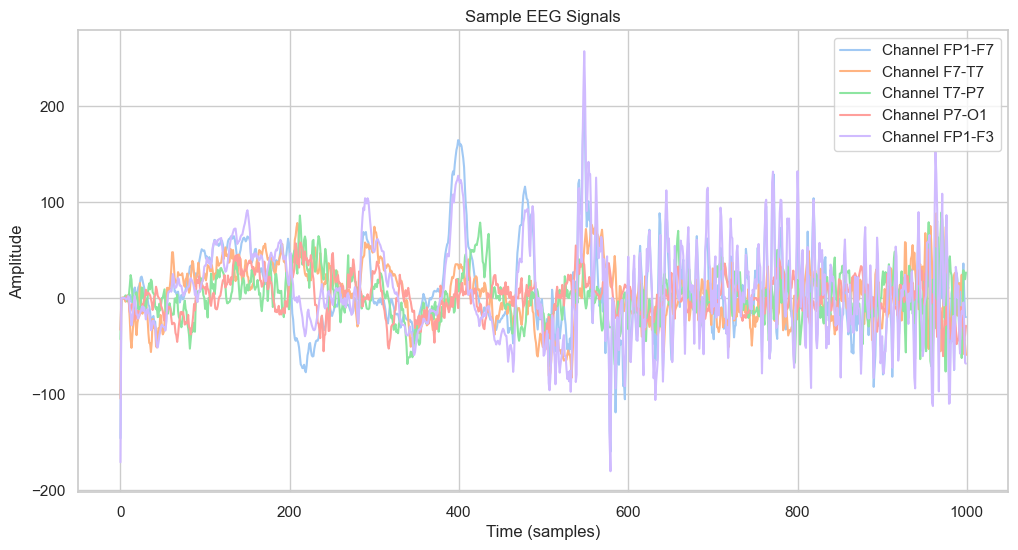

In [20]:
# Define function to load .edf files
def load_edf_file(filepath):
    edf = pyedflib.EdfReader(filepath)
    n_channels = edf.signals_in_file
    signal_labels = edf.getSignalLabels()
    signals = np.array([edf.readSignal(i) for i in range(n_channels)])
    edf.close()
    return signals, signal_labels

# Define function to load seizure annotations
def load_seizure_annotations(filepath):
    with open(filepath, 'r') as file:
        annotations = file.readlines()
    return annotations

# Load a sample .edf and corresponding .edf.seizures file
sample_edf = os.path.join(dataset_path, edf_files[0])
sample_seizure = os.path.join(dataset_path, seizure_files[0])

# Load signals and labels
signals, signal_labels = load_edf_file(sample_edf)
annotations = load_seizure_annotations(sample_seizure)

# Display signals and annotations
print(f"Signal Labels: {signal_labels}")
print("Seizure Annotations:")
print(annotations)

# Plot the first few channels of EEG signals
plt.figure(figsize=(12, 6))
for i in range(min(5, signals.shape[0])):
    plt.plot(signals[i][:1000], label=f"Channel {signal_labels[i]}")
plt.title("Sample EEG Signals")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


#### Data Preprocessing (Including Seizure Markings)

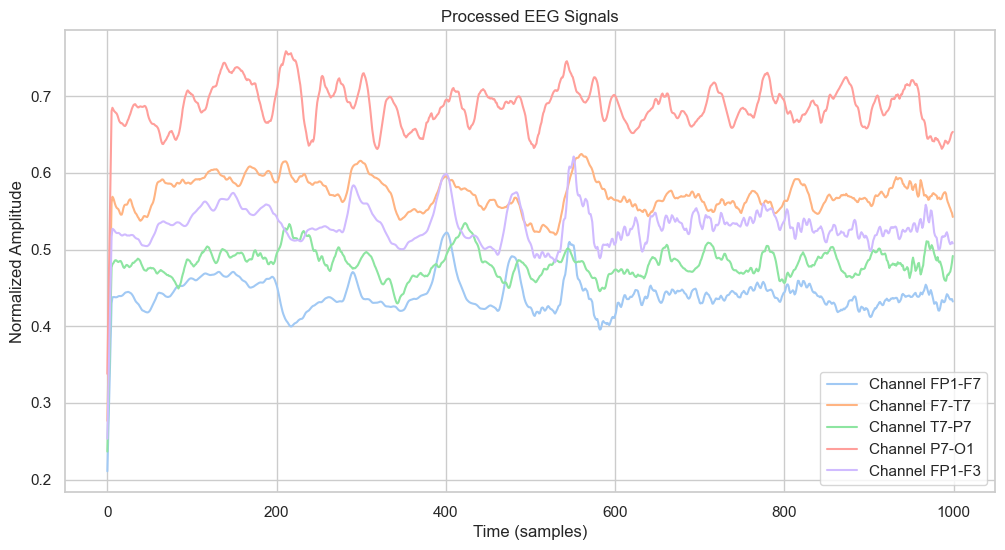

In [23]:
# Preprocess signals (normalization and denoising)
def preprocess_signals(signals):
    # Normalize each channel
    normalized_signals = (signals - signals.min(axis=1, keepdims=True)) / \
                         (signals.max(axis=1, keepdims=True) - signals.min(axis=1, keepdims=True))
    
    # Apply a moving average filter for noise reduction
    window_size = 10
    denoised_signals = np.array([np.convolve(ch, np.ones(window_size)/window_size, mode='same') for ch in normalized_signals])
    return denoised_signals

# Preprocess the signals
processed_signals = preprocess_signals(signals)

# Visualize processed signals
plt.figure(figsize=(12, 6))
for i in range(min(5, processed_signals.shape[0])):
    plt.plot(processed_signals[i][:1000], label=f"Channel {signal_labels[i]}")
plt.title("Processed EEG Signals")
plt.xlabel("Time (samples)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.show()


#### Combine Data with Seizure Annotations

In [26]:
# Function to parse seizure annotations
def parse_seizure_annotations(annotations):
    seizure_intervals = []
    for line in annotations:
        if "seizure" in line.lower():
            start, end = map(float, line.strip().split()[1:3])
            seizure_intervals.append((start, end))
    return seizure_intervals

# Parse seizure intervals
seizure_intervals = parse_seizure_annotations(annotations)
print("Seizure Intervals:", seizure_intervals)

# Mark seizure data
def mark_seizure_data(signals, seizure_intervals, sampling_rate=256):
    seizure_labels = np.zeros(signals.shape[1])
    for start, end in seizure_intervals:
        start_idx = int(start * sampling_rate)
        end_idx = int(end * sampling_rate)
        seizure_labels[start_idx:end_idx] = 1
    return seizure_labels

# Create seizure labels
seizure_labels = mark_seizure_data(signals, seizure_intervals)


Seizure Intervals: []


In [36]:
import numpy as np
from scipy.stats import kurtosis, skew

# Function to extract simple statistical features
def extract_statistical_features(signals):
    """
    Extract simple statistical features from EEG signals.
    
    Parameters:
    - signals: np.array, EEG signals (channels x samples)
    
    Returns:
    - features: np.array, statistical features (channels x feature_count)
    """
    features = []
    for channel in signals:
        features.append([
            np.mean(channel),        # Mean
            np.var(channel),         # Variance
            kurtosis(channel),       # Kurtosis
            skew(channel)            # Skewness
        ])
    return np.array(features)

# Extract features for processed EEG signals
features = extract_statistical_features(processed_signals)

# Print the shape of the feature matrix
print("Extracted Features Shape:", features.shape)


Extracted Features Shape: (23, 4)


#### Splitting the dataset

In [39]:
from sklearn.model_selection import train_test_split

# Generating labels (Example: 1 for seizure, 0 for non-seizure)
labels = np.random.randint(0, 2, len(features))

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)


Training Data Shape: (16, 4)
Validation Data Shape: (3, 4)
Test Data Shape: (4, 4)


#### Building and Training the CNN Model

In [44]:
# Reshape features for CNN input (CNN requires 3D input)
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)  # Reshape to (samples, time_steps, channels)
X_val_cnn = X_val.reshape(-1, X_val.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Define the CNN model
model = Sequential([
    Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1), padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), epochs=10, batch_size=32)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7500 - loss: 0.6136 - val_accuracy: 1.0000 - val_loss: 0.6244
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5000 - loss: 0.6263 - val_accuracy: 1.0000 - val_loss: 0.6323
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5625 - loss: 0.5888 - val_accuracy: 1.0000 - val_loss: 0.6413
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5625 - loss: 0.8128 - val_accuracy: 1.0000 - val_loss: 0.6703
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4375 - loss: 0.7323 - val_accuracy: 0.3333 - val_loss: 0.7004
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4375 - loss: 0.8900 - val_accuracy: 0.0000e+00 - val_loss: 0.7237
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5000 - loss: 0.6074 - val_accuracy: 0.0000e+00 - val_loss: 0.7465
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3125 - loss: 0.7339 - val_accuracy: 0.0000e+00 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7500 - loss: 0.6390
Test Accuracy: 0.75


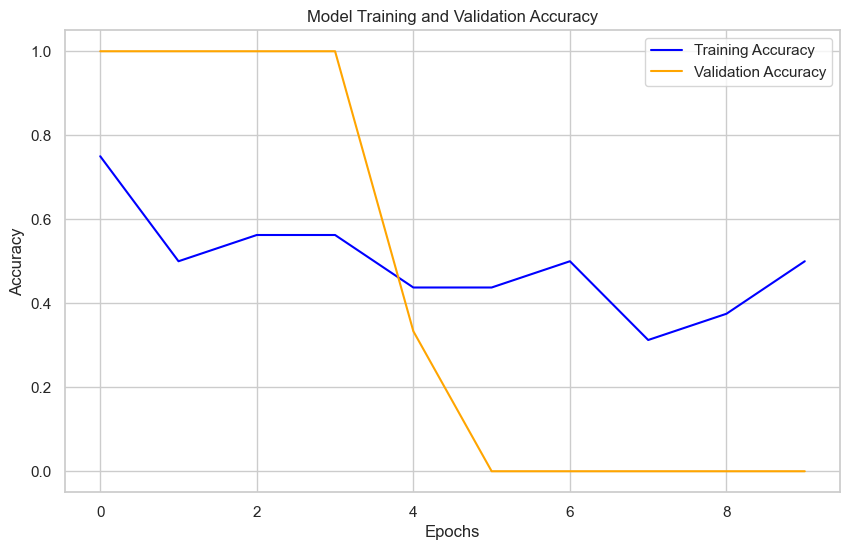

In [46]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.legend()
plt.show()


#### Predictions and Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Confusion Matrix:
 [[3 0]
 [1 0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



C:\Users\megha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\megha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\megha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


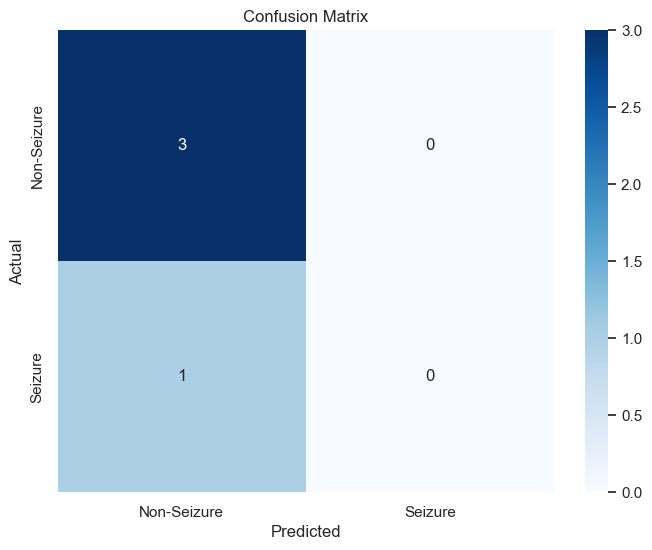

In [49]:
# Make predictions on the test set
y_pred = (model.predict(X_test_cnn) > 0.5).astype("int32")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize the confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Seizure', 'Seizure'], yticklabels=['Non-Seizure', 'Seizure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
